# 机器人自动走迷宫

<br>
<hr>

# 1. 实验介绍  

## 1.1 实验内容  
在本实验中，要求分别使用基础搜索算法和 Deep QLearning 算法，完成机器人自动走迷宫。
 
<img src="https://imgbed.momodel.cn/20200914145238.png" width="40%"/>

如上图所示，左上角的红色椭圆既是起点也是机器人的初始位置，右下角的绿色方块是出口。          
游戏规则为：从起点开始，通过错综复杂的迷宫，到达目标点(出口)。
        
+ 在任一位置可执行动作包括：向上走 `'u'`、向右走 `'r'`、向下走 `'d'`、向左走 `'l'`。

+ 执行不同的动作后，根据不同的情况会获得不同的奖励，具体而言，有以下几种情况。
    - 撞墙
    - 走到出口
    - 其余情况
    
    
+ 需要您分别实现**基于基础搜索算法**和 **Deep QLearning 算法**的机器人，使机器人自动走到迷宫的出口。

## 1.2 实验要求 
+ 使用 Python 语言。
+ 使用基础搜索算法完成机器人走迷宫。
+ 使用 Deep QLearning 算法完成机器人走迷宫。
+ 算法部分需要自己实现，不能使用现成的包、工具或者接口。


## 1.3 实验环境
可以使用 Python 实现基础算法的实现， 使用 Keras、PyTorch等框架实现 Deep QLearning 算法。

## 1.4 注意事项
+ Python 与 Python Package 的使用方式，可在右侧 `API文档` 中查阅。
+ 当右上角的『Python 3』长时间指示为运行中的时候，造成代码无法执行时，可以重新启动 Kernel 解决（左上角『Kernel』-『Restart Kernel』）。

## 1.5 参考资料
+  强化学习入门MDP：https://zhuanlan.zhihu.com/p/25498081
+ QLearning 示例：http://mnemstudio.org/path-finding-q-learning-tutorial.htm
+ QLearning 知乎解释：https://www.zhihu.com/question/26408259
+ DeepQLearning 论文：https://files.momodel.cn/Playing%20Atari%20with%20Deep%20Reinforcement%20Learning.pdf


# 2. 实验内容



## 2.1 Maze 类介绍

### 2.1.1 创建迷宫
通过迷宫类 Maze 可以随机创建一个迷宫。

1. 使用  Maze(maze_size=size)  来随机生成一个 size * size 大小的迷宫。
2. 使用 print() 函数可以输出迷宫的 size 以及画出迷宫图
3. 红色的圆是机器人初始位置
4. 绿色的方块是迷宫的出口位置

In [1]:
# 导入相关包
import os
import random
import time
import numpy as np
from Maze import Maze
from Runner import Runner
from QRobot import QRobot
from ReplayDataSet import ReplayDataSet
from torch_py.MinDQNRobot import MinDQNRobot as TorchRobot # PyTorch版本
from keras_py.MinDQNRobot import MinDQNRobot as KerasRobot # Keras版本
import matplotlib.pyplot as plt


/home/zbw/miniconda3/envs/zju-ai-course/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-25 12:17:44.713850: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-25 12:17:44.727165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1729858664.743819 2892764 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1729858664.748993 2892764 cuda_blas.

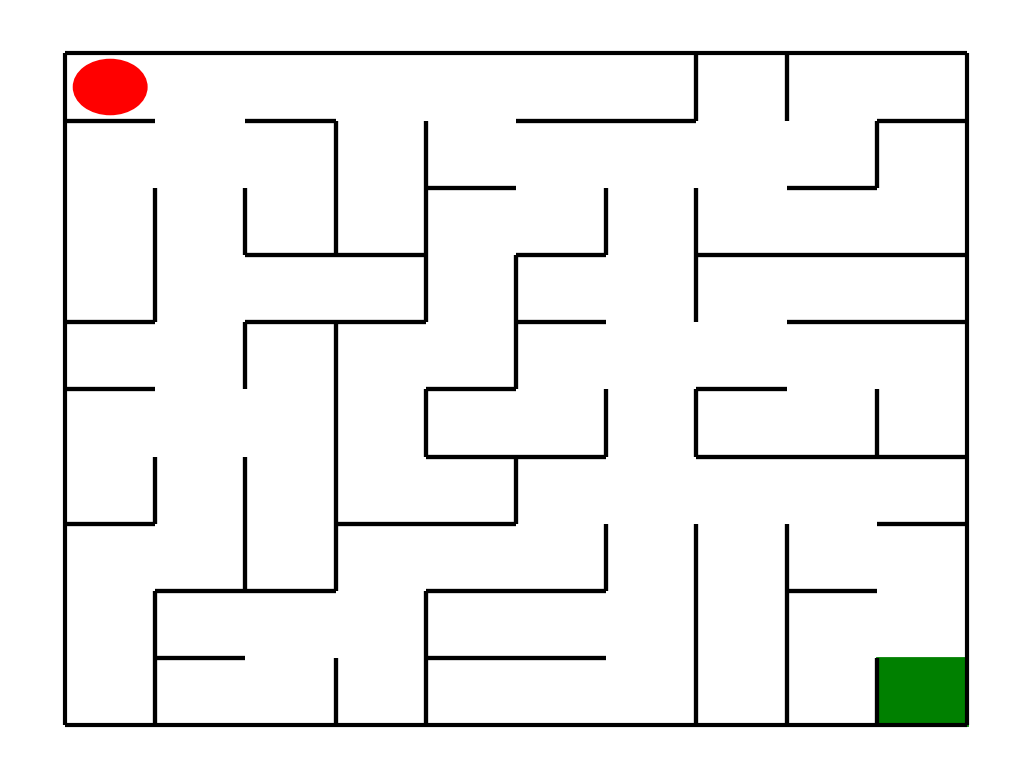

Maze of size (10, 10)


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

""" 创建迷宫并展示 """
maze = Maze(maze_size=10) # 随机生成迷宫
print(maze)


### 2.1.2 重要的成员方法
在迷宫中已经初始化一个机器人，你要编写的算法实现在给定条件下控制机器人移动至目标点。

Maze 类中重要的成员方法如下：

1. sense_robot() ：获取机器人在迷宫中目前的位置。

> return：机器人在迷宫中目前的位置。

2. move_robot(direction) ：根据输入方向移动默认机器人，若方向不合法则返回错误信息。

> direction：移动方向, 如:"u", 合法值为： ['u', 'r', 'd', 'l']

> return：执行动作的奖励值

3. can_move_actions(position)：获取当前机器人可以移动的方向

> position：迷宫中任一处的坐标点 

> return：该点可执行的动作，如：['u','r','d']

4. is_hit_wall(self, location, direction)：判断该移动方向是否撞墙

> location, direction：当前位置和要移动的方向，如(0,0) , "u"

> return：True(撞墙) / False(不撞墙)

5. draw_maze()：画出当前的迷宫


**随机移动机器人，并记录下获得的奖励，展示出机器人最后的位置。**

the history of rewards: [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]
the actions ['r', 'r', 'r', 'd', 'u', 'd', 'u', 'l', 'l', 'd']
the end position of robot: (1, 1)


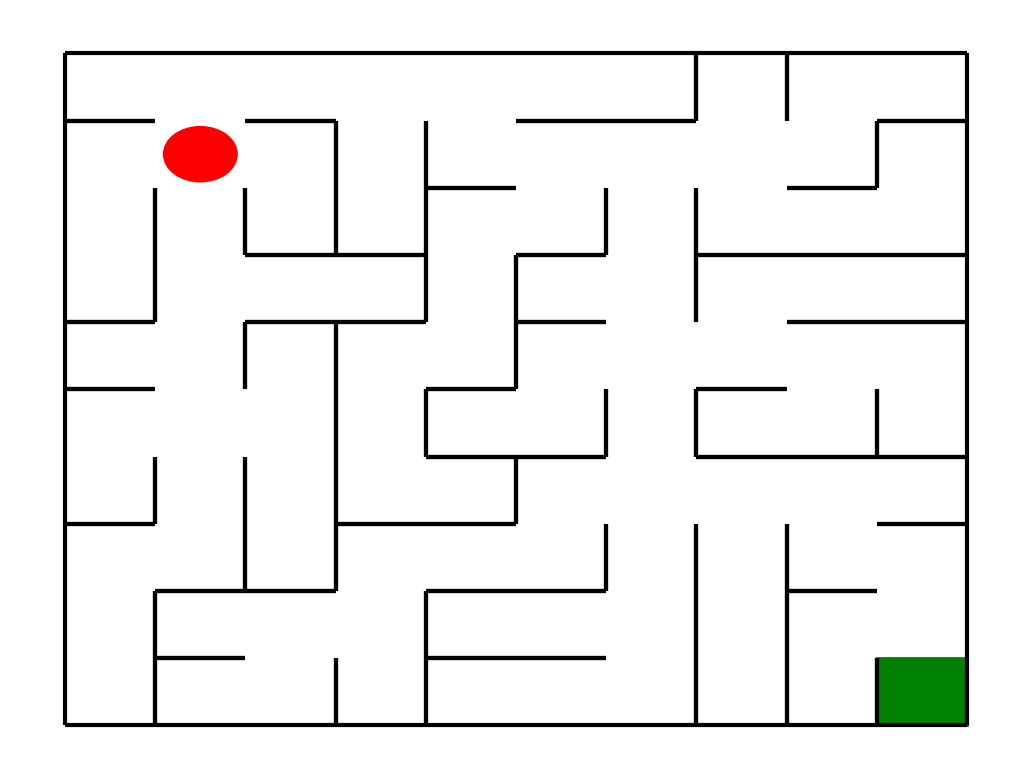

Maze of size (10, 10)


In [3]:
import random

rewards = [] # 记录每走一步的奖励值
actions = [] # 记录每走一步的移动方向

# 循环、随机移动机器人10次，记录下奖励
for i in range(10):
    valid_actions = maze.can_move_actions(maze.sense_robot())
    action = random.choice(valid_actions)
    rewards.append(maze.move_robot(action))
    actions.append(action)

print("the history of rewards:", rewards)
print("the actions", actions)

# 输出机器人最后的位置
print("the end position of robot:", maze.sense_robot())

# 打印迷宫，观察机器人位置
print(maze)


## 2.2 基础搜索算法介绍（广度优先搜索算法）

对于迷宫游戏，常见的三种的搜索算法有广度优先搜索、深度优先搜索和最佳优先搜索（A*)。


在下面的代码示例中，将实现广度优先搜索算法；主要通过建立一颗搜索树并进行层次遍历实现。
+ 每个节点表示为以 `Class SearchTree` 实例化的对象，类属性有：**当前节点位置、到达当前节点的动作、当前节点的父节点、当前节点的子节点**；
+ `valid_actions():` 用以获取机器人可以行走的位置（即不能穿墙）；
+ `expand():` 对于未拓展的子节点进行拓展；
+ `backpropagation():` 回溯搜索路径。

### 2.2.1 算法具体步骤

首先以机器人起始位置建立根节点，并入队；接下来不断重复以下步骤直到判定条件:

1. 将队首节点的位置标记已访问；判断队首是否为目标位置(出口)， **是** 则终止循环并记录回溯路径
2. 判断队首节点是否为叶子节点，**是** 则拓展该叶子节点
3. 如果队首节点有子节点，则将每个子节点插到队尾
4. 将队首节点出队

### 2.2.2 编程实现广度优先搜索算法

In [24]:
import numpy as np

# 机器人移动方向
move_map = {
    'u': (-1, 0), # up
    'r': (0, +1), # right
    'd': (+1, 0), # down
    'l': (0, -1), # left
}


# 迷宫路径搜索树
class SearchTree(object):


    def __init__(self, loc=(), action='', parent=None):
        """
        初始化搜索树节点对象
        :param loc: 新节点的机器人所处位置
        :param action: 新节点的对应的移动方向
        :param parent: 新节点的父辈节点
        """

        self.loc = loc  # 当前节点位置
        self.to_this_action = action  # 到达当前节点的动作
        self.parent = parent  # 当前节点的父节点
        self.children = []  # 当前节点的子节点

    def add_child(self, child):
        """
        添加子节点
        :param child:待添加的子节点
        """
        self.children.append(child)

    def is_leaf(self):
        """
        判断当前节点是否是叶子节点
        """
        return len(self.children) == 0


def expand(maze, is_visit_m, node):
    """
    拓展叶子节点，即为当前的叶子节点添加执行合法动作后到达的子节点
    :param maze: 迷宫对象
    :param is_visit_m: 记录迷宫每个位置是否访问的矩阵
    :param node: 待拓展的叶子节点
    """
    can_move = maze.can_move_actions(node.loc)
    for a in can_move:
        new_loc = tuple(node.loc[i] + move_map[a][i] for i in range(2))
        if not is_visit_m[new_loc]:
            child = SearchTree(loc=new_loc, action=a, parent=node)
            node.add_child(child)


def back_propagation(node):
    """
    回溯并记录节点路径
    :param node: 待回溯节点
    :return: 回溯路径
    """
    path = []
    while node.parent is not None:
        path.insert(0, node.to_this_action)
        node = node.parent
    return path


def breadth_first_search(maze):
    """
    对迷宫进行广度优先搜索
    :param maze: 待搜索的maze对象
    """
    start = maze.sense_robot()
    root = SearchTree(loc=start)
    queue = [root]  # 节点队列，用于层次遍历
    h, w, _ = maze.maze_data.shape
    is_visit_m = np.zeros((h, w), dtype=np.int32)  # 标记迷宫的各个位置是否被访问过
    path = []  # 记录路径
    while True:
        current_node = queue[0]
        is_visit_m[current_node.loc] = 1  # 标记当前节点位置已访问

        if current_node.loc == maze.destination:  # 到达目标点
            path = back_propagation(current_node)
            break

        if current_node.is_leaf():
            expand(maze, is_visit_m, current_node)

        # 入队
        for child in current_node.children:
            queue.append(child)

        # 出队
        queue.pop(0)

    return path


**测试广度优先搜索算法**

In [48]:
maze = Maze(maze_size=1000)
height, width, _ = maze.maze_data.shape

start = time.time()
path_1 = breadth_first_search(maze)
end = time.time()
print(f"搜索时间：{end - start} 秒")
print("搜索出的路径：", path_1)
print(f"路径长度：{len(path_1)}")

for action in path_1:
    maze.move_robot(action)

if maze.sense_robot() == maze.destination:
    print("恭喜你，到达了目标点")

# print(maze)


搜索时间：36.79349446296692 秒
搜索出的路径： ['d', 'r', 'r', 'r', 'u', 'r', 'd', 'r', 'd', 'd', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'd', 'r', 'r', 'r', 'r', 'r', 'd', 'r', 'r', 'r', 'r', 'u', 'u', 'r', 'r', 'd', 'r', 'r', 'r', 'd', 'l', 'd', 'r', 'd', 'r', 'r', 'd', 'r', 'r', 'r', 'r', 'd', 'd', 'r', 'r', 'r', 'r', 'r', 'u', 'r', 'd', 'r', 'd', 'r', 'r', 'r', 'r', 'r', 'r', 'd', 'r', 'r', 'r', 'r', 'd', 'd', 'd', 'd', 'd', 'r', 'r', 'd', 'l', 'd', 'r', 'r', 'd', 'd', 'r', 'r', 'r', 'r', 'r', 'd', 'r', 'r', 'r', 'r', 'r', 'd', 'r', 'r', 'u', 'r', 'd', 'r', 'd', 'd', 'd', 'd', 'r', 'd', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'u', 'r', 'r', 'r', 'd', 'r', 'r', 'd', 'l', 'd', 'r', 'r', 'r', 'd', 'r', 'r', 'd', 'd', 'r', 'd', 'r', 'd', 'r', 'r', 'd', 'r', 'r', 'd', 'd', 'd', 'r', 'r', 'r', 'r', 'd', 'r', 'r', 'd', 'l', 'd', 'd', 'r', 'r', 'd', 'r', 'd', 'd', 'l', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'r', 'd', 'd', 'd', 'r', 'd', 'd', 'd', 'd', 'r', 'd', 'r', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', '

## 2.3 题目一: 实现基础搜索算法（40分）
* 题目要求： 任选深度优先搜索算法、最佳优先搜索 A* 算法其中一种实现机器人走迷宫

* 输入：迷宫

* 输出：到达目标点的路径

    

### 2.3.1 编写您的基础搜索算法

In [42]:
import heapq

def manhattan_distance(p1, p2):
    """
    计算两点间的曼哈顿距离作为启发式函数
    """
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

def my_search(maze: Maze):
    """
    任选深度优先搜索算法、最佳优先搜索（A*)算法实现其中一种
    :param maze: 迷宫对象
    :return :到达目标点的路径 如：["u","u","r",...]
    """

    path = []

    # -----------------请实现你的算法代码--------------------------------------
    start = maze.sense_robot()
    goal = maze.destination

    # 记录已访问的节点
    h, w, _ = maze.maze_data.shape
    visited = np.zeros((h, w), dtype=np.int32)

    # 起始节点
    root = SearchTree(loc=start)

    open_list = [(manhattan_distance(start, goal), id(root), 0, root)]
    heapq.heapify(open_list)

    while open_list:
        f_score, _, g_score, node = heapq.heappop(open_list)
        # 到达目标点，回溯路径
        if node.loc == goal:
            path = back_propagation(node)
            break

        # 标记已访问
        visited[node.loc] = 1

        # 获取当前位置可执行的动作
        valid_actions = maze.can_move_actions(node.loc)

        # 拓展节点
        for action in valid_actions:
            new_loc = tuple(node.loc[i] + move_map[action][i] for i in range(2))

            if visited[new_loc]:
                continue

            # 创建新节点
            child = SearchTree(loc=new_loc, action=action, parent=node)
            node.add_child(child)

            # 计算新节点的g值(实际代价）和h值(预估代价，启发式函数)
            new_g = g_score + 1
            new_h = manhattan_distance(new_loc, goal)
            new_f = new_g + new_h

            # 入队
            heapq.heappush(open_list, (new_f, id(child), new_g, child))

    # -----------------------------------------------------------------------
    return path


### 2.3.2 测试您编写的基础搜索算法

In [47]:
maze = Maze(maze_size=1000) # 从文件生成迷宫

start = time.time()
path_2 = my_search(maze)
end = time.time()
print(f"搜索时间：{end - start} 秒")
print("搜索出的路径：", path_2)
print(f"路径长度：{len(path_2)}")

for action in path_2:
    maze.move_robot(action)


if maze.sense_robot() == maze.destination:
    print("恭喜你，到达了目标点")


搜索时间：23.517221689224243 秒
搜索出的路径： ['r', 'r', 'r', 'r', 'd', 'd', 'r', 'd', 'r', 'r', 'r', 'd', 'r', 'r', 'r', 'r', 'u', 'r', 'd', 'r', 'd', 'd', 'r', 'r', 'r', 'r', 'r', 'd', 'r', 'd', 'r', 'r', 'd', 'r', 'r', 'd', 'r', 'r', 'd', 'd', 'd', 'r', 'd', 'd', 'r', 'r', 'd', 'd', 'd', 'r', 'd', 'r', 'r', 'd', 'd', 'r', 'r', 'u', 'r', 'u', 'r', 'd', 'd', 'd', 'r', 'd', 'r', 'd', 'r', 'd', 'd', 'r', 'd', 'd', 'd', 'r', 'd', 'd', 'r', 'd', 'd', 'r', 'd', 'd', 'r', 'r', 'd', 'd', 'r', 'r', 'r', 'd', 'r', 'd', 'd', 'd', 'd', 'd', 'r', 'r', 'r', 'd', 'd', 'd', 'd', 'd', 'd', 'r', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'r', 'd', 'd', 'r', 'r', 'd', 'r', 'r', 'd', 'r', 'r', 'r', 'r', 'u', 'r', 'r', 'd', 'd', 'l', 'd', 'd', 'r', 'r', 'd', 'd', 'd', 'r', 'd', 'd', 'l', 'd', 'd', 'r', 'r', 'd', 'd', 'd', 'r', 'd', 'd', 'd', 'r', 'r', 'd', 'r', 'd', 'r', 'r', 'r', 'r', 'd', 'r', 'r', 'r', 'd', 'r', 'r', 'r', 'd', 'r', 'd', 'd', 'd', 'd', 'r', 'r', 'r', 'd', 'r', 'r', 'd', 'd', 'r', 'd', 'r', 'd', 'r', 'r', 

## 2.4 强化学习算法介绍

强化学习作为机器学习算法的一种，其模式也是让智能体在“训练”中学到“经验”，以实现给定的任务。    
但不同于监督学习与非监督学习，在强化学习的框架中，我们更侧重通过智能体与环境的**交互**来学习。   
通常在监督学习和非监督学习任务中，智能体往往需要通过给定的训练集，辅之以既定的训练目标（如最小化损失函数），通过给定的学习算法来实现这一目标。    
然而在强化学习中，智能体则是通过其与环境交互得到的奖励进行学习。     
这个环境可以是虚拟的（如虚拟的迷宫），也可以是真实的（自动驾驶汽车在真实道路上收集数据）。


在强化学习中有五个核心组成部分，它们分别是：**环境（Environment）**、**智能体（Agent）**、**状态（State）**、**动作（Action）**和**奖励（Reward）**。

在某一时间节点 $t$：
    
- 智能体在从环境中感知其所处的状态 $s_t$
- 智能体根据某些准则选择动作 $a_t$
- 环境根据智能体选择的动作，向智能体反馈奖励 $r_{t+1}$

通过合理的学习算法，智能体将在这样的问题设置下，成功学到一个在状态 $s_t$ 选择动作 $a_t$ 的策略 $\pi (s_t) = a_t$。

<img src="https://imgbed.momodel.cn/20200914153419.png" width=400px/>



## 2.5 QLearning 算法

Q-Learning 是一个值迭代（Value Iteration）算法。    
与策略迭代（Policy Iteration）算法不同，值迭代算法会计算每个”状态“或是”状态-动作“的值（Value）或是效用（Utility），然后在执行动作的时候，会设法最大化这个值。    
因此，对每个状态值的准确估计，是值迭代算法的核心。    
通常会考虑**最大化动作的长期奖励**，即不仅考虑当前动作带来的奖励，还会考虑动作长远的奖励。



### 2.5.1 Q 值的计算与迭代

Q-learning 算法将状态（state）和动作（action）构建成一张 Q_table 表来存储 Q 值，Q 表的行代表状态（state），列代表动作（action）：

<img src="https://imgbed.momodel.cn/20200914161241.png" width=400px/>

在 Q-Learning 算法中，将这个长期奖励记为 Q 值，其中会考虑每个 ”状态-动作“ 的 Q 值，具体而言，它的计算公式为：

$$
Q(s_{t},a) = R_{t+1} + \gamma \times\max_a Q(a,s_{t+1})
$$

也就是对于当前的“状态-动作” $(s_{t},a)$，考虑执行动作 $a$ 后环境奖励 $R_{t+1}$，以及执行动作 $a$ 到达 $s_{t+1}$后，执行任意动作能够获得的最大的Q值 $\max_a Q(a,s_{t+1})$，$\gamma$ 为折扣因子。

计算得到新的 Q 值之后，一般会使用更为保守地更新 Q 表的方法，即引入松弛变量 $alpha$ ，按如下的公式进行更新，使得 Q 表的迭代变化更为平缓。

$$
Q(s_{t},a) = (1-\alpha) \times Q(s_{t},a) + \alpha \times(R_{t+1} + \gamma \times\max_a Q(a,s_{t+1}))
$$

### 2.5.2 机器人动作的选择

在强化学习中，**探索-利用** 问题是非常重要的问题。    
具体来说，根据上面的定义，会尽可能地让机器人在每次选择最优的决策，来最大化长期奖励。    
但是这样做有如下的弊端：    
1. 在初步的学习中，Q 值是不准确的，如果在这个时候都按照 Q 值来选择，那么会造成错误。
2. 学习一段时间后，机器人的路线会相对固定，则机器人无法对环境进行有效的探索。

因此需要一种办法，来解决如上的问题，增加机器人的探索。   
通常会使用 **epsilon-greedy** 算法：
1. 在机器人选择动作的时候，以一部分的概率随机选择动作，以一部分的概率按照最优的 Q 值选择动作。
2. 同时，这个选择随机动作的概率应当随着训练的过程逐步减小。

<img src="http://imgbed.momodel.cn/20200602153554.png" width=400>
<img src="http://imgbed.momodel.cn/20200601144827.png" width=400>

### 2.5.3  Q-Learning 算法的学习过程
<img src="http://imgbed.momodel.cn/20200601170657.png" width=900>

###  2.5.4 Robot 类

在本作业中提供了 QRobot 类，其中实现了 Q 表迭代和机器人动作的选择策略，可通过 `from QRobot import QRobot` 导入使用。

**QRobot 类的核心成员方法**

1. sense_state()：获取当前机器人所处位置

> return：机器人所处的位置坐标，如： (0, 0)

2. current_state_valid_actions()：获取当前机器人可以合法移动的动作

> return：由当前合法动作组成的列表，如： ['u','r']

3. train_update()：以**训练状态**，根据 QLearning 算法策略执行动作

> return：当前选择的动作，以及执行当前动作获得的回报, 如： 'u', -1

4. test_update()：以**测试状态**，根据 QLearning 算法策略执行动作

> return：当前选择的动作，以及执行当前动作获得的回报, 如：'u', -1

5. reset()

> return：重置机器人在迷宫中的位置

In [4]:
from QRobot import QRobot
from Maze import Maze

maze = Maze(maze_size=5) # 随机生成迷宫

robot = QRobot(maze) # 记得将 maze 变量修改为你创建迷宫的变量名

action, reward = robot.train_update() # QLearning 算法一次Q值迭代和动作选择

print("the choosed action: ", action)
print("the returned reward: ", reward)



the choosed action:  u
the returned reward:  -10.0


### 2.5.5 Runner 类

QRobot 类实现了 QLearning 算法的 Q 值迭代和动作选择策略。在机器人自动走迷宫的训练过程中，需要不断的使用 QLearning 算法来迭代更新 Q 值表，以达到一个“最优”的状态，因此封装好了一个类 Runner 用于机器人的训练和可视化。可通过 `from Runner import Runner` 导入使用。



**Runner 类的核心成员方法：**

1. run_training(training_epoch, training_per_epoch=150): 训练机器人，不断更新 Q 表，并讲训练结果保存在成员变量 train_robot_record 中

> training_epoch, training_per_epoch: 总共的训练次数、每次训练机器人最多移动的步数

2. run_testing()：测试机器人能否走出迷宫

3. generate_gif(filename)：将训练结果输出到指定的 gif 图片中

> filename：合法的文件路径,文件名需以 `.gif` 为后缀

4. plot_results()：以图表展示训练过程中的指标：Success Times、Accumulated Rewards、Runing Times per Epoch



**设定训练参数、训练、查看结果**

In [5]:
from QRobot import QRobot
from Maze import Maze
from Runner import Runner

"""  Qlearning 算法相关参数： """

epoch = 10  # 训练轮数
epsilon0 = 0.5  # 初始探索概率
alpha = 0.5  # 公式中的 ⍺
gamma = 0.9  # 公式中的 γ
maze_size = 5  # 迷宫size

""" 使用 QLearning 算法训练过程 """

g = Maze(maze_size=maze_size)
r = QRobot(g, alpha=alpha, epsilon0=epsilon0, gamma=gamma)

runner = Runner(r)
runner.run_training(epoch, training_per_epoch=int(maze_size * maze_size * 1.5))

# 生成训练过程的gif图, 建议下载到本地查看；也可以注释该行代码，加快运行速度。
runner.generate_gif(filename="results/size5.gif")


正在将训练过程转换为gif图, 请耐心等候...:  99%|█████████▉| 338/341 [00:11<00:00, 30.69it/s]

正在将训练过程转换为gif图, 请耐心等候...: 100%|██████████| 341/341 [00:29<00:00, 30.69it/s]

正在将训练过程转换为gif图, 请耐心等候...: 100%|██████████| 341/341 [01:24<00:00,  4.02it/s]


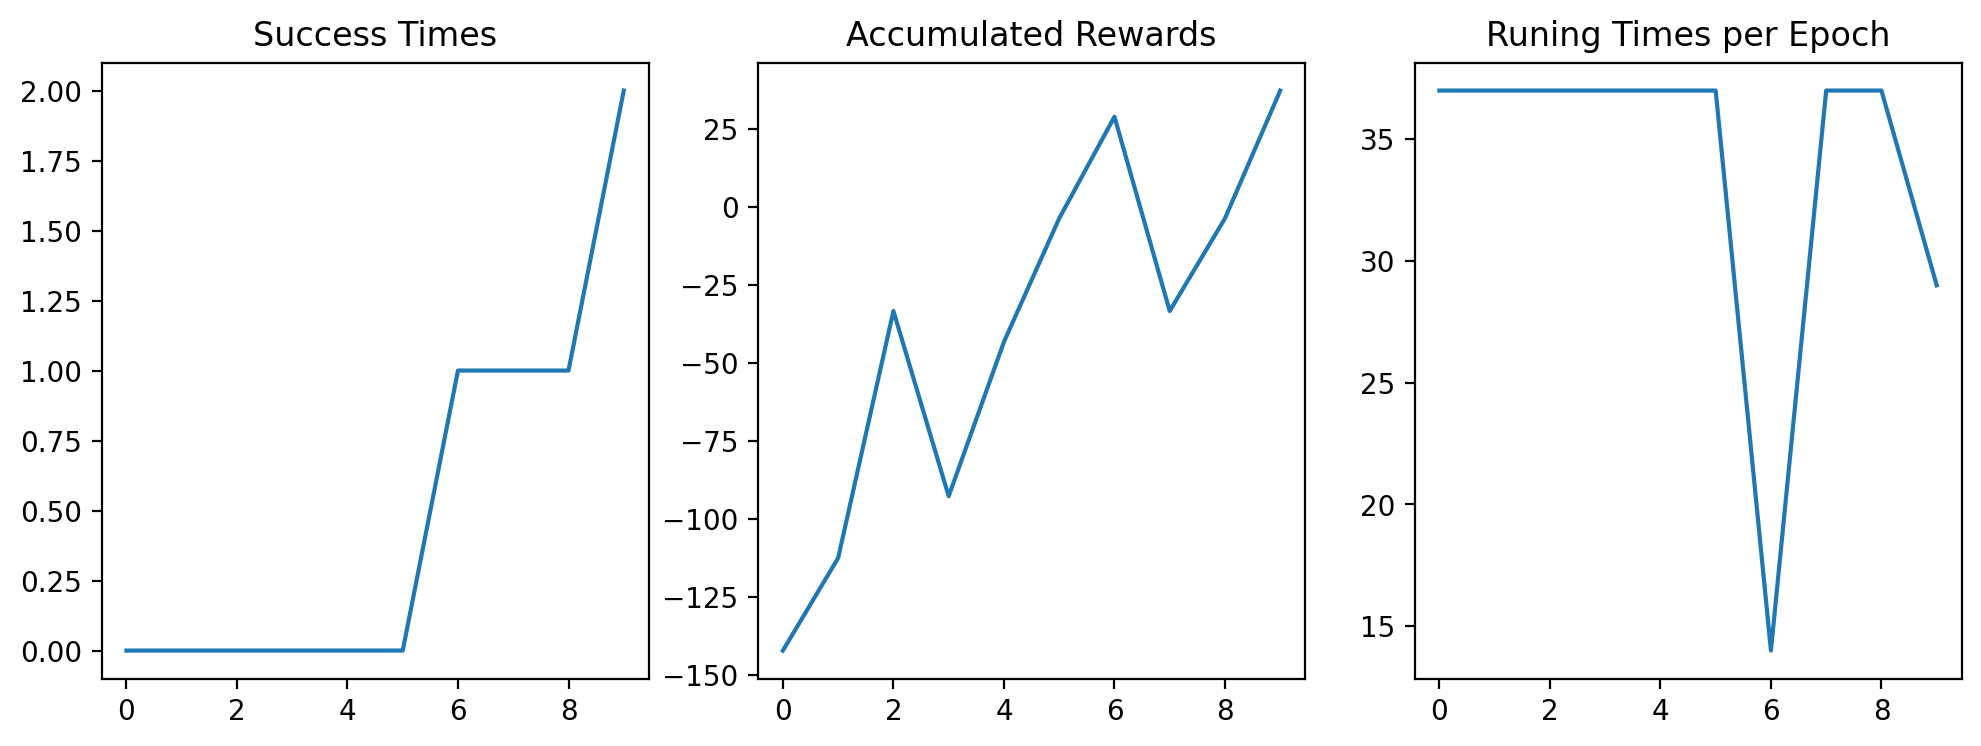

In [6]:
runner.plot_results() # 输出训练结果，可根据该结果对您的机器人进行分析。


## 2.6 题目二: 实现 Deep QLearning 算法（60分）

### 2.6.1 DQN 算法介绍
强化学习是一个反复迭代的过程，每一次迭代要解决两个问题：给定一个策略求值函数，和根据值函数来更新策略。而 DQN 算法使用神经网络来近似值函数。([DQN 论文地址](https://files.momodel.cn/Playing%20Atari%20with%20Deep%20Reinforcement%20Learning.pdf))

+ **DQN 算法流程**

<img src="https://imgbed.momodel.cn/20200918101051.png" width="60%"/>

+ **DQN 算法框架图**

<img src="https://imgbed.momodel.cn/20200918101137.png" width="60%"/>


### 2.6.2 完成 DQN 算法

**ReplayDataSet 类的核心成员方法**

+ add(self, state, action_index, reward, next_state, is_terminal) 添加一条训练数据

> state: 当前机器人位置

> action_index: 选择执行动作的索引

> reward： 执行动作获得的回报

> next_state：执行动作后机器人的位置

> is_terminal：机器人是否到达了终止节点（到达终点或者撞墙）

+ random_sample(self, batch_size)：从数据集中随机抽取固定batch_size的数据

> batch_size: 整数，不允许超过数据集中数据的个数

+ **build_full_view(self, maze)：开启金手指，获取全图视野**

> maze: 以 Maze 类实例化的对象

In [8]:
"""ReplayDataSet 类的使用"""

from ReplayDataSet import ReplayDataSet

test_memory = ReplayDataSet(max_size=1e3) # 初始化并设定最大容量
actions = ['u', 'r', 'd', 'l']
test_memory.add((0,1), actions.index("r"), -10, (0,1), 1)  # 添加一条数据（state, action_index, reward, next_state）
print(test_memory.random_sample(1)) # 从中随机抽取一条（因为只有一条数据）


(array([[0, 1]]), array([[1]], dtype=int8), array([[-10]]), array([[0, 1]]), array([[1]], dtype=int8))


#### （1）实现简单的 DQNRobot

作业中提供了简单的 DQNRobot 实现，其中依靠简单的两层全连接神经网络决策动作

<div align=left>
<center><img src="https://imgbed.momodel.cn/20201029220521.png" width="241px"/>
</div>

+ **该神经网络的输入：机器人当前的位置坐标，输出：执行四个动作（up、right、down、left）的评估分数**

该部分我们支持 PyTorch 版本和 Keras 版本，大家可以选择自己擅长的深度学习框架！！！ 我们已经实现简单的 DQNRobot 部分，大家可以完善该部分代码！！！

In [3]:
from torch_py.MinDQNRobot import MinDQNRobot as TorchRobot # PyTorch版本
from keras_py.MinDQNRobot import MinDQNRobot as KerasRobot # Keras版本

import matplotlib.pyplot as plt
from Maze import Maze
from Runner import Runner
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # 允许重复载入lib文件
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

maze = Maze(maze_size=5)


"""选择keras版本或者torch版本的机器人, MinRobot是尽量选择reward值最小的动作，对象初始化过程中修改了maze的reward参数"""
# robot = KerasRobot(maze=maze)
robot = TorchRobot(maze=maze)

print(robot.maze.reward) # 输出最小值选择策略的reward值

"""开启金手指，获取全图视野"""
robot.memory.build_full_view(maze=maze) #

"""training by runner"""
runner = Runner(robot=robot)
runner.run_training(training_epoch=10, training_per_epoch=75)

"""Test Robot"""
robot.reset()
for _ in range(25):
    a, r = robot.test_update()
    print("action:", a, "reward:", r)
    if r == maze.reward["destination"]:
        print("success")
        break


RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [4]:
import torch
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
a = torch.randn(10, 10).to(device)

RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


#### （2）实现你自己的 DQNRobot

 + **题目要求:** 编程实现 DQN 算法在机器人自动走迷宫中的应用
 + **输入:** 由 Maze 类实例化的对象 maze
 + **要求不可更改的成员方法：**train_update()、test_update() **注：不能修改该方法的输入输出及方法名称，测试评分会调用这两个方法**。
 + **补充1:**若要自定义的参数变量，在 \_\_init\_\_() 中以 `self.xxx = xxx` 创建即可
 + **补充2:**实现你自己的DQNRobot时，要求继承 QRobot 类，QRobot 类包含了某些固定的方法如reset(重置机器人位置),sense_state(获取机器人当前位置)..

In [ ]:
from QRobot import QRobot

class Robot(QRobot):

    def __init__(self, maze):
        """
        初始化 Robot 类
        :param maze:迷宫对象
        """
        super(Robot, self).__init__(maze)
        self.maze = maze

    def train_update(self):
        """
        以训练状态选择动作并更新Deep Q network的相关参数
        :return :action, reward 如："u", -1
        """
        action, reward = "u", -1.0

        # -----------------请实现你的算法代码--------------------------------------

        # -----------------------------------------------------------------------

        return action, reward

    def test_update(self):
        """
        以测试状态选择动作并更新Deep Q network的相关参数
        :return : action, reward 如："u", -1
        """
        action, reward = "u", -1.0

        # -----------------请实现你的算法代码--------------------------------------

        # -----------------------------------------------------------------------

        return action, reward


#### （3）测试您的 DQN 算法


In [ ]:
from QRobot import QRobot
from Maze import Maze
from Runner import Runner

"""  Deep Qlearning 算法相关参数： """

epoch = 10  # 训练轮数
maze_size = 5  # 迷宫size
training_per_epoch=int(maze_size * maze_size * 1.5)

""" 使用 DQN 算法训练 """

g = Maze(maze_size=maze_size)
r = Robot(g)
runner = Runner(r)
runner.run_training(epoch, training_per_epoch)

# 生成训练过程的gif图, 建议下载到本地查看；也可以注释该行代码，加快运行速度。
runner.generate_gif(filename="results/dqn_size10.gif")


### 2.6.3 作业测试与提交

- 经过 `2.3` 与 `2.6` 分别测试使用基础算法、DQN算法实现机器人走出迷宫！
- 测试完成之后，点击左侧 `提交作业` 的标签中，把整个 Notebook 目标 cell 转化为 main.py 文件进行`系统测试`。
- 平台测试时请记得勾选 main.py 文件需要依赖的其它文件等。
- 通过测试就可以**提交作业**。
-  提交作业时请记得提交勾选 **『程序报告.docx』**或者 **『程序报告.pdf』**。

作业评分说明：
1. 满分100分，基础算法通过迷宫得 40 分， DQN 算法通过初级、中级、高级迷宫分别得 20 分。

**最后，祝愿您不仅能从中收获到满满的知识，而且收获到一个满意分数！**